In [ ]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
import contractions
import spacy

nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
nlp = spacy.load("en_core_web_sm")
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from imblearn.over_sampling import RandomOverSampler

/home/tanwa/ml/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-08-04 13:41:56.185540: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-04 13:41:57.107128: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-08-04 13:41:57.107267: W tensorflow/compiler/xla/stream_executor/platf

In [31]:
train_df = pd.read_csv('dataset/healthver_train.csv')
test_df = pd.read_csv('dataset/healthver_test.csv')
val_df = pd.read_csv('dataset/healthver_dev.csv')

In [36]:
train_df.isnull().sum()

id          0
evidence    0
claim       0
label       0
topic_ip    0
question    0
dtype: int64

In [37]:
test_df.isnull().sum()

id          0
evidence    0
claim       0
label       0
topic_ip    0
question    0
dtype: int64

In [38]:
val_df.isnull().sum()

id          0
evidence    0
claim       0
label       0
topic_ip    0
question    0
dtype: int64

In [3]:
train_df['topic_ip'].values

array([28, 60, 44, ..., 22, 16, 42])

In [4]:
val_df['topic_ip'].values

array([  1,  42,  42, ..., 116,   3,  10])

# Label Distribution

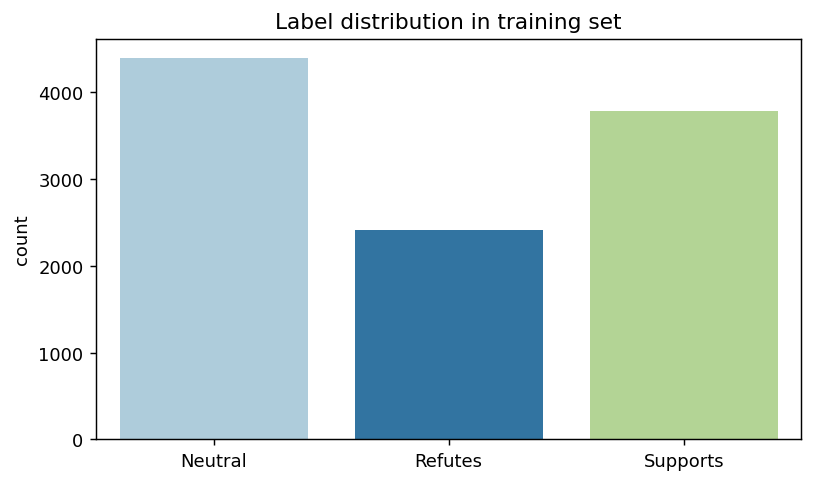

In [5]:
plt.figure(figsize=(7,4), dpi=130)
plt.title('Label distribution in training set')
sorted_train_df = train_df['label'].sort_values()
sns.countplot(x=sorted_train_df.values, palette = 'Paired')
sns.set(style='whitegrid')

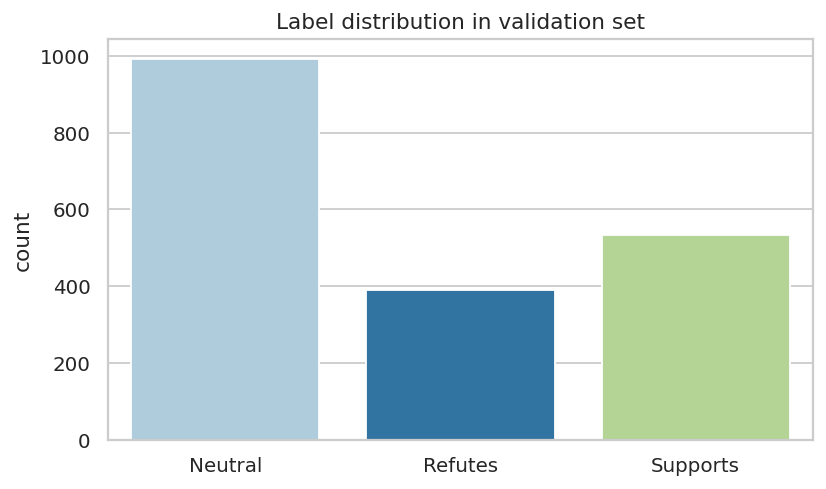

In [6]:
plt.figure(figsize=(7,4), dpi=130)
plt.title('Label distribution in validation set')
sorted_val_df = val_df['label'].sort_values()
sns.countplot(x=sorted_val_df.values, palette = 'Paired')
sns.set(style='whitegrid')

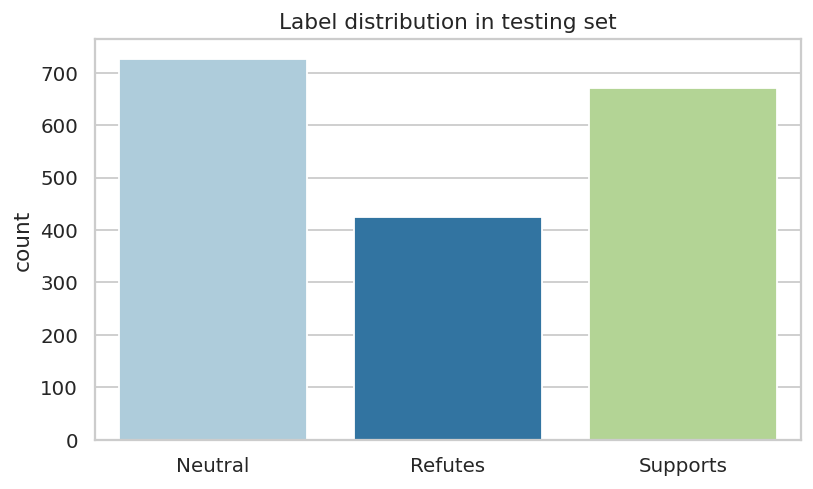

In [7]:
plt.figure(figsize=(7,4), dpi=130)
plt.title('Label distribution in testing set')
sorted_test_df = test_df['label'].sort_values()
sns.countplot(x=sorted_test_df.values, palette = 'Paired')
sns.set(style='whitegrid')

# Topic Distribution

In [8]:
train_df['topic_ip'].unique()

array([ 28,  60,  44,   4, 125,  52,  42,   5,   3,   2,  51,  95,  43,
        54,  16,   1,  22,  82, 134,  93,  31,  63,  53,  19, 135,  55,
        69,  20, 105,  10, 119, 129,  56,  67, 141,  24,  23,  75,  17,
       114,  18,  26,  58,  30, 103,  27,  21,  90, 107,  87,  80,  45,
       148, 101, 124,  33, 154, 112, 116,  86, 108, 104,  46, 120,  84,
        97, 117, 142,  73,  92,  99,  39,  85, 109, 132,  47,   6, 111,
       106,  25])

In [9]:
len(train_df['topic_ip'].unique())

80

<AxesSubplot:title={'center':'Distribution of topics by labels in training set'}, xlabel='topic_ip'>

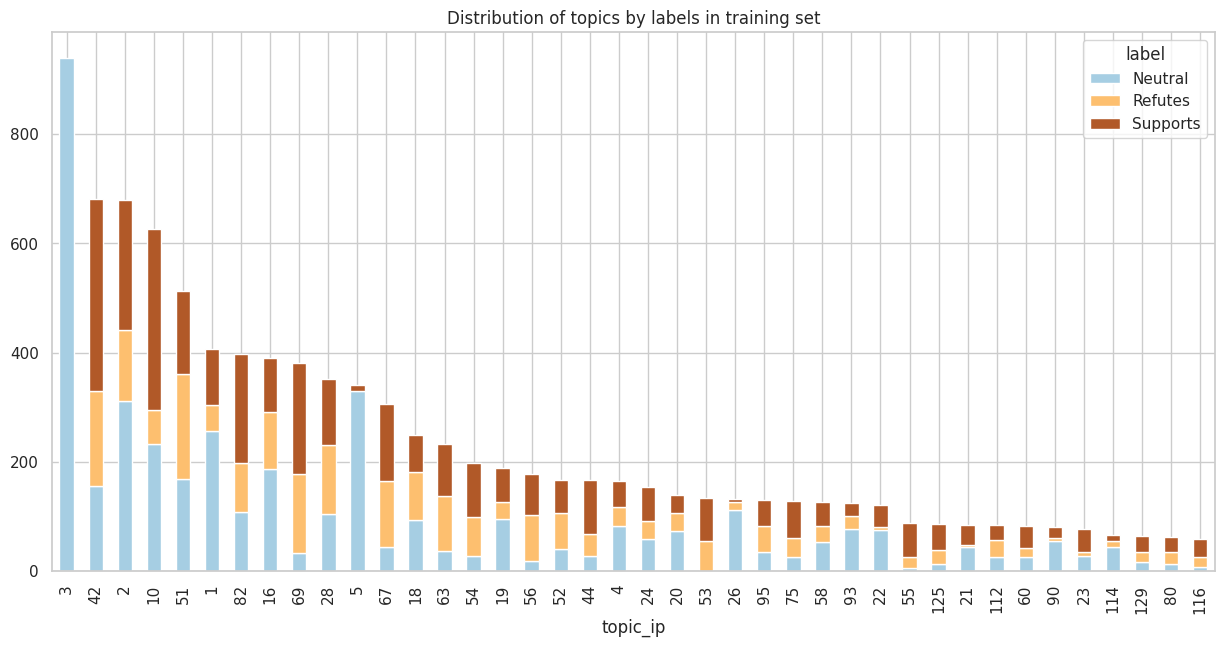

In [10]:
train_df_grouped = train_df.groupby(['label', 'topic_ip']).size().reset_index().pivot(columns='label', index='topic_ip', values=0)
train_df_grouped.fillna(0, inplace=True)
train_df_grouped['Total'] = train_df_grouped['Neutral'] + train_df_grouped['Refutes'] + train_df_grouped['Supports']
train_df_grouped.sort_values('Total', inplace=True, ascending=False)
train_df_grouped.drop(columns='Total', inplace=True)
train_df_grouped[:40].plot(kind='bar',colormap='Paired',stacked=True, figsize=(15,7), title='Distribution of topics by labels in training set')

<AxesSubplot:title={'center':'Distribution of topics by labels in validation set'}, xlabel='topic_ip'>

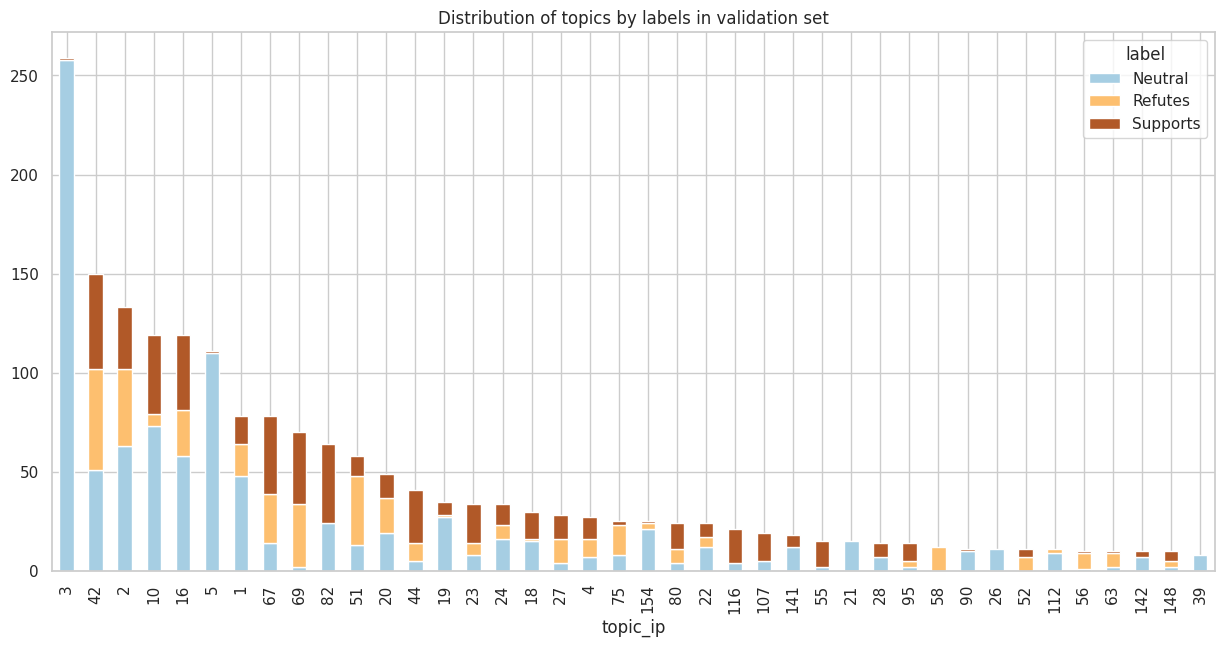

In [11]:

#df_plot.plot(kind='bar', stacked=True)
val_df_grouped = val_df.groupby(['label', 'topic_ip']).size().reset_index().pivot(columns='label', index='topic_ip', values=0)
val_df_grouped.fillna(0, inplace=True)
val_df_grouped['Total'] = val_df_grouped['Neutral'] + val_df_grouped['Refutes'] + val_df_grouped['Supports']
val_df_grouped.sort_values('Total', inplace=True, ascending=False)
val_df_grouped.drop(columns='Total', inplace=True)
val_df_grouped[:40].plot(kind='bar', stacked=True, figsize=(15,7), title='Distribution of topics by labels in validation set', colormap='Paired')

<AxesSubplot:title={'center':'Distribution of topics by labels in test set'}, xlabel='topic_ip'>

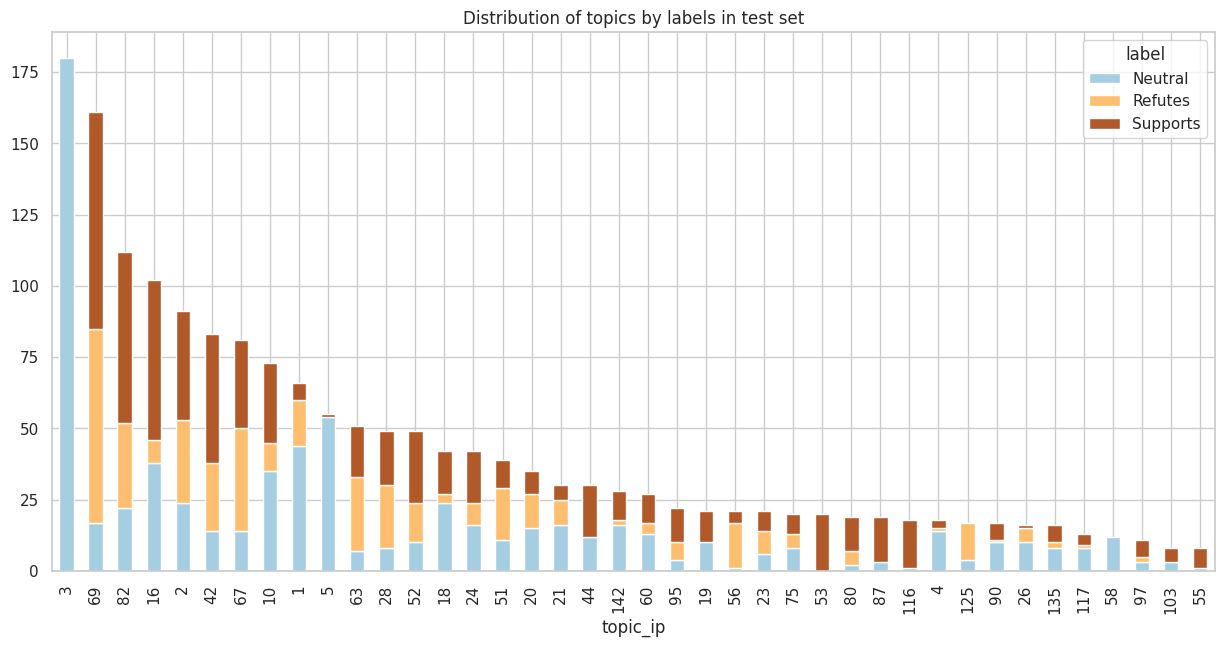

In [12]:

#df_plot.plot(kind='bar', stacked=True)
test_df_grouped = test_df.groupby(['label', 'topic_ip']).size().reset_index().pivot(columns='label', index='topic_ip', values=0)
test_df_grouped.fillna(0, inplace=True)
test_df_grouped['Total'] = test_df_grouped['Neutral'] + test_df_grouped['Refutes'] + test_df_grouped['Supports']
test_df_grouped.sort_values('Total', inplace=True, ascending=False)
test_df_grouped.drop(columns='Total', inplace=True)
test_df_grouped[:40].plot(kind='bar', stacked=True, figsize=(15,7), title='Distribution of topics by labels in test set', colormap='Paired')

# Histogram

In [13]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bionlp/bluebert_pubmed_uncased_L-12_H-768_A-12")

In [14]:
tokens = tokenizer.tokenize(train_df['claim'][0], max_length=128, padding='max_length', truncation=True,
                               return_tensors='pt')

In [24]:
token_lengths = []

for evidence in train_df['evidence']:
  tokens = tokenizer.encode(evidence, max_length=512)
  token_lengths.append(len(tokens))
  #print(tokens)
max_length = max(token_lengths)


In [27]:
print(min(token_lengths))
print(np.mean(token_lengths))
print(np.std(token_lengths))

9
49.824929178470256
31.71313436549494


Text(0.5, 12.44444444444443, 'Evidence token length')

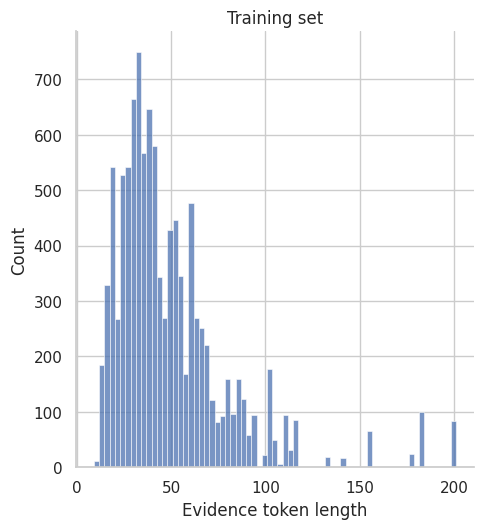

In [23]:
sns.displot(token_lengths)
plt.title('Training set')
plt.xlabel('Evidence token length')

In [28]:
token_lengths = []

for claim in train_df['claim']:
  tokens = tokenizer.encode(claim, max_length=512)
  token_lengths.append(len(tokens))
max_length = max(token_lengths)

In [30]:
max_length

127

In [29]:
print(min(token_lengths))
print(np.mean(token_lengths))
print(np.std(token_lengths))

7
26.21954674220963
13.45109897474414


Text(0.5, 12.44444444444443, 'Claim token length')

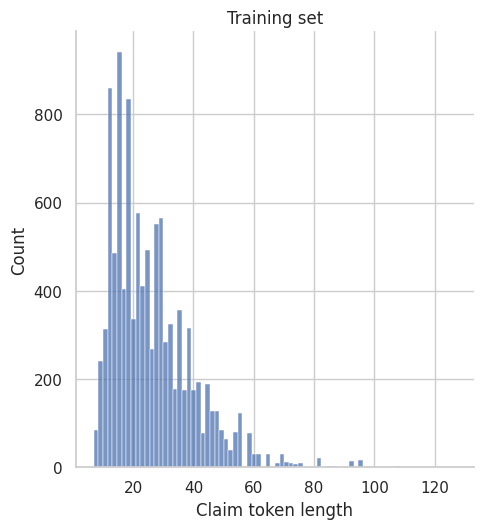

In [21]:
sns.displot(token_lengths)
plt.title('Training set')
plt.xlabel('Claim token length')